# TELSEM Atlas
I will try to re implement the logic behind the FORTRAN functions that rerad the atlas, in order to have the same data stored in a .nc file using python.

In [1]:
#
import numpy as np
import os

errorstatus_fatal = -1

The main subroutine we are interested in is called get_coordinates, and it takes the cell number and the atlas object, and returns the latitude and longitude.
---

SUBROUTINE get_coordinates(cellnum,self,lat,lon)
    !======computes lat and lon given the cellnumber
    IMPLICIT none
    INTEGER, INTENT (IN) :: cellnum
    type(telsem2_atlas_data), INTENT (IN) :: atlas
    REAL(jprb), INTENT (OUT) :: lat, lon
    !INTEGER :: ilat,ilon
    INTEGER :: i
    REAL :: res_lat ! latitude resolution
    INTEGER :: index_lat_max,index_lat,index_lon

    res_lat = atlas%dlat

    index_lat_max  = int(180/res_lat)

    IF (cellnum >= atlas%firstcell(index_lat_max)) THEN
       index_lat = index_lat_max
       lat =(index_lat - 0.5)*res_lat - 90
       index_lon = cellnum - atlas%firstcell(index_lat_max)+1
       lon = (index_lon - 0.5)*(360.0/atlas%ncells(index_lat))
    ELSE
       DO i=1,index_lat_max-1
          IF ( (cellnum>=atlas%firstcell(i)) .AND. (cellnum<atlas%firstcell(i+1)) ) THEN
             index_lat = i
             lat = (index_lat - 0.5)*res_lat- 90
             ! cout << i << "  " << *lat <<endl;
             index_lon = cellnum - atlas%firstcell(i)+1
             lon = (index_lon - 0.5)*(360.0/atlas%ncells(index_lat))
          END IF
       END DO
    END IF
  END SUBROUTINE get_coordinates


In [2]:
class Telsem2AtlasData:
    def __init__(self):
        # number of lines in the atlas
        self.ndat = None
        # number of channels in the atlas
        self.nchan = 7
        # name of the atlas (including version number)
        self.name = ""
        # month of the atlas
        self.month = None
        # resolution of the atlas (equal-area)
        self.dlat = 0.25
        # number of cells per lat band
        self.ncells = None
        # the first cellnumber of lat band
        self.firstcell = None
        # limits of the spatial domain (flagged if global)
        self.lat1 = None
        self.lat2 = None
        self.lon1 = None
        self.lon2 = None
        # Emissivities
        self.emis = None  # emis(ndat,nchan)
        # Correlations
        self.correl = None  # correl(10,nchan,nchan)
        # Emissivity uncertainties (std)
        self.emis_err = None  # emis_err(ndat,nchan)
        # Surface class
        self.class1 = None
        self.class2 = None
        # cellnumber of each of the pixels in the atlas
        self.cellnum = None
        # "Correspondance" vector indicating that for the ith element, the j so that EMIS(j,...) is the emissivity of cellnumber i.
        self.correspondance = None  # correspondance(660066)

In [ ]:
# TODO: Design a propper class with methods, instead of this awfull frankenstein

In [3]:
def get_coordinates(cellnum: int, atlas: Telsem2AtlasData):

    res_lat = atlas.dlat

    index_lat_max = int(180 / res_lat) - 1

    if cellnum >= atlas.firstcell[index_lat_max]:
        index_lat = index_lat_max
        lat = (index_lat - 0.5) * res_lat - 90
        index_lon = cellnum - atlas.firstcell[index_lat_max] + 1
        lon = (index_lon - 0.5) * (360.0 / atlas.ncells[index_lat])

    else:
        for i in range(1, index_lat_max - 1):
            if cellnum >= atlas.firstcell[i] and cellnum < atlas.firstcell[i + 1]:
                index_lat = i
                lat = (index_lat - 0.5) * res_lat - 90
                index_lon = cellnum - atlas.firstcell[i] + 1
                lon = (index_lon - 0.5) * (360.0 / atlas.ncells[index_lat])

    return lat, lon

In [4]:
# Equal area computations


def equare(dlat, ncells, firstcell):
    # EQUAL-AREA COMPUTATIONS
    maxlat = int(180.0 / dlat)
    maxlon = int(360.0 / dlat)

    tocell = np.zeros((maxlon, maxlat), dtype=np.int32)

    REARTH = 6371.2
    PI = 2.0 * np.arcsin(1.0)
    RCELAT = (dlat * PI) / 180.0
    TOTCEL = 0

    HEZON = REARTH * np.sin(RCELAT)
    AEZON = 2.0 * PI * REARTH * HEZON
    AECELL = (AEZON * dlat) / 360.0

    MAXLT2 = maxlat // 2
    for lat in range(1, MAXLT2 + 1):
        XLATB = (lat - 1) * dlat
        XLATE = XLATB + dlat
        RLATB = (2.0 * PI * XLATB) / 360.0
        RLATE = (2.0 * PI * XLATE) / 360.0

        HTB = REARTH * np.sin(RLATB)
        HTE = REARTH * np.sin(RLATE)
        HTZONE = HTE - HTB
        AZONE = 2.0 * PI * REARTH * HTZONE

        RCELLS = AZONE / AECELL
        ICELLR = int(RCELLS + 0.5)

        TOTCEL += 2 * ICELLR

        lat1 = lat + MAXLT2
        lat2 = MAXLT2 + 1 - lat
        ncells[lat1 - 1] = ICELLR
        ncells[lat2 - 1] = ICELLR

    numcel = 0
    for lat in range(1, maxlat + 1):
        numcls = ncells[lat - 1]
        for lon in range(1, numcls + 1):
            numcel += 1
            tocell[lon - 1, lat - 1] = numcel

    for i in range(1, maxlat + 1):
        if i == 1:
            firstcell[i - 1] = 1
        else:
            firstcell[i - 1] = firstcell[i - 2] + ncells[i - 2]

Finally, mimic the functions that populate the class by reading the atlas file

In [5]:
def rttov_readmw_atlas(
    dir,
    month,
    atlas: Telsem2AtlasData,
    verbose=False,
    lat1=None,
    lat2=None,
    lon1=None,
    lon2=None,
):
    # Read a monthly atlas

    # TRANSITORY VARIABLES
    iiin = 21  # unit for input
    cellnum = 0
    ssmi = np.zeros(2 * 7, dtype=np.float64)
    lat, lon = 0.0, 0.0
    cur_class1, cur_class2 = 0, 0
    take = 0  # flag to take or not the pixel atlas for location constraints
    msg = ""

    # initialisation
    err = 0

    if atlas.emis is not None:
        err = errorstatus_fatal
        print("TELSEM2 atlas data structure already allocated")
        return err

    month2 = f"{month:02d}"

    atlas.month = month
    atlas.lat1 = -777
    atlas.lat2 = -777
    atlas.lon1 = -777
    atlas.lon2 = -777

    if lat1 is not None:
        atlas.lat1 = lat1
    if lat2 is not None:
        atlas.lat2 = lat2
    if lon1 is not None:
        atlas.lon1 = lon1 % 360.0
    if lon2 is not None:
        atlas.lon2 = lon2 % 360.0

    # ALLOCATION SPECIFIC TO SSMI ATLAS
    atlas.nchan = 7
    atlas.name = "ssmi_mean_emis_climato"
    atlas.dlat = 0.25
    atlas.ncells = np.zeros(int(180.0 / atlas.dlat), dtype=np.int32)
    atlas.firstcell = np.zeros(int(180.0 / atlas.dlat), dtype=np.int32)
    equare(atlas.dlat, atlas.ncells, atlas.firstcell)

    # DEFINING NUMBER OF DATA
    if verbose:
        print("Reading number of data in atlas...")

    try:
        iiin_file = open(
            os.path.join(dir, atlas.name + "_" + month2 + "_cov_interpol_M2"), "r"
        )
        j = int(iiin_file.readline().strip())
        atlas.ndat = j
        if verbose:
            print(f"Nb data={atlas.ndat}")
    except IOError as e:
        print(f"Error opening the monthly input file: {e}")
        err = errorstatus_fatal
        return err

    # ALLOCATE VARIABLES
    atlas.emis = np.zeros((atlas.ndat, atlas.nchan), dtype=np.float64)
    atlas.emis_err = np.zeros((atlas.ndat, atlas.nchan), dtype=np.float64)
    atlas.class1 = np.zeros(atlas.ndat, dtype=np.int32)
    atlas.class2 = np.zeros(atlas.ndat, dtype=np.int32)
    atlas.cellnum = np.zeros(atlas.ndat, dtype=np.int32)
    atlas.correspondance = np.full(660066, -777, dtype=np.int32)

    ipos = 0
    for line in iiin_file:
        parts = line.strip().split()
        cellnum, ssmi_values, cur_class1, cur_class2 = (
            int(parts[0]),
            list(map(float, parts[1:15])),
            int(parts[15]),
            int(parts[16]),
        )

        take = 1
        if lat1 is not None:
            get_coordinates(cellnum, atlas, lat, lon)
            if not (lat1 <= lat <= lat2 and lon1 <= lon <= lon2):
                take = 0

        if cur_class1 > 0 and cur_class2 > 0 and ipos < atlas.ndat and take == 1:
            ipos += 1
            atlas.emis[ipos - 1, :] = ssmi_values[:7]
            atlas.emis_err[ipos - 1, :] = np.sqrt(ssmi_values[7:])
            atlas.cellnum[ipos - 1] = cellnum
            atlas.class1[ipos - 1] = cur_class1
            atlas.class2[ipos - 1] = cur_class2
            atlas.correspondance[cellnum - 1] = ipos

    atlas.ndat = ipos
    iiin_file.close()

    # Correlation of uncertainties
    atlas.correl = np.zeros((10, atlas.nchan, atlas.nchan), dtype=np.float64)

    if verbose:
        print("Reading classes...")

    try:
        iiin_file = open(os.path.join(dir, "correlations"), "r")
        for i in range(10):
            iiin_file.readline()  # skip lines
            for j in range(7):
                atlas.correl[i, j, :] = np.array(
                    list(map(float, iiin_file.readline().strip().split()))
                )
    except IOError as e:
        print(f"Error opening the correlations input file: {e}")
        err = errorstatus_fatal
        return err
    finally:
        iiin_file.close()

    return err

In [16]:
# Lets create the full grid using all the cell numbers possible, not only the ones in the atlas

cell_grids = [i for i in range(1,1440*720)]
atlas = Telsem2AtlasData()
rttov_readmw_atlas(
    dir=r"C:\Users\andre\Desktop\TELSEM\telsem2_mw_atlas",
    atlas=atlas,
    month=2,
)

cell_grids = atlas.cellnum

coordinates = [get_coordinates(c, atlas=atlas) for c in cell_grids ]

In [23]:
atlas.dlat

0.25

In [34]:
def get_all_coordinates(cellnum):

    res_lat = 0.25

    index_lat_max = 719 # int (180/0.25) -1
    
    if cellnum >= 660064: # atlas.firstcell[719]
        index_lat = index_lat_max
        lat = (index_lat - 0.5) * res_lat - 90
        index_lon = cellnum - atlas.firstcell[index_lat_max] + 1
        lon = (index_lon - 0.5) * (360.0 / atlas.ncells[index_lat])

    else:
        for i in range(1, index_lat_max + 1):
            if cellnum >= atlas.firstcell[i] and cellnum < atlas.firstcell[i + 1]:
                index_lat = i
                lat = (index_lat - 0.5) * res_lat - 90
                index_lon = cellnum - atlas.firstcell[i] + 1
                lon = (index_lon - 0.5) * (360.0 / atlas.ncells[index_lat])
            else:
                lat = -1
                lon = -1
    return lat, lon

all_coordinates = [get_all_coordinates(cn) for cn in range(1, 10000)]

In [42]:
# Longitude points per latitude
ncells_per_lat = atlas.ncells

res_lat = 0.25
lat_band_number = 720

coordinates = []
for i in range(lat_band_number):
    for j in range(atlas.ncells[i]):
        lat = (i - 0.50) *res_lat -90
        lon = (j - 0.5) * (360/atlas.ncells[i])

        coordinates.append((lon,lat))

print(len(coordinates))


660066


In [75]:
660066/(2*3*11*73*137)


1.0

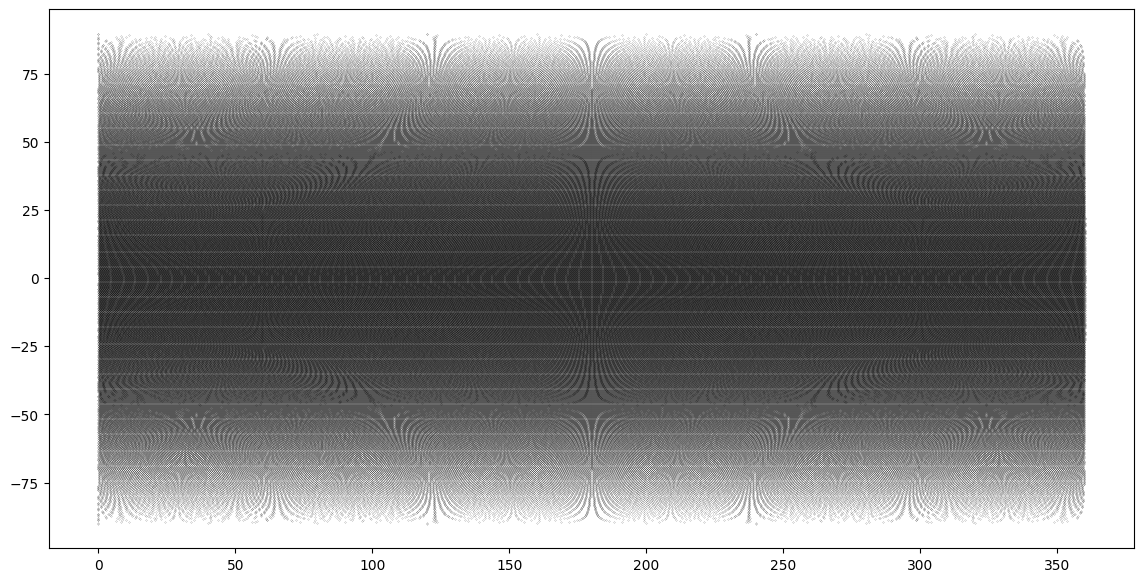

In [82]:
# unravel and check that we have all the coordinates:
import matplotlib.pyplot as plt

lons = [(coord[0] + 180) % 360 for coord in coordinates]
lats = [coord[1] for coord in coordinates]
# Correct the longitudes so GM = 180
plt.figure(figsize=(14,7))
plt.scatter(lons, lats, c="black", s=0.01)

In [ ]:
# With all cells we can create a grid:



In [6]:
# Read the atlas into the Telsem2AtlasData class.
atlas = Telsem2AtlasData()

rttov_readmw_atlas(
    dir=r"C:\Users\andre\Desktop\TELSEM\telsem2_mw_atlas",
    atlas=atlas,
    month=2,
)

0

In [7]:
# Now lets add the coordinates of each cell into a dataframe for example:
cell_numbers = atlas.cellnum
coordinates = [get_coordinates(atlas=atlas, cellnum=cn) for cn in cell_numbers]

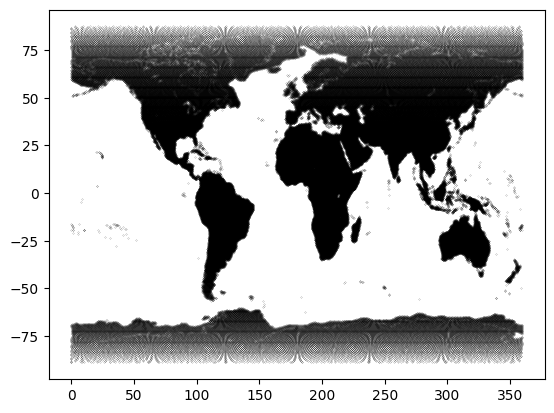

In [36]:
import matplotlib.pyplot as plt

lats = [coord[0] for coord in coordinates]
# Correct the longitudes so GM = 180

lons = [(coord[1] + 180) % 360 for coord in coordinates]

plt.scatter(lons, lats, c="black", s=0.01)


In [11]:
# Lets try to create a geopandas object with the atlas, so that we have the latitude and longitude
import geopandas
from shapely.geometry import Point
import pandas as pd

coordinates = [Point(lon, lat) for lat, lon in zip(lats, lons)]

gdf = geopandas.GeoDataFrame(geometry=coordinates)

# Create dataframes for emisivities and errors:
emisdf = pd.DataFrame(
    atlas.emis,
    columns=[
        "Emis19V",
        "Emis19H",
        "Emis22V",
        "Emis37V",
        "Emis37H",
        "Emis85V",
        "Emis85H",
    ],
)

errdf = pd.DataFrame(
    atlas.emis_err,
    columns=[
        "VarEmis19V",
        "VarEmis19H",
        "VarEmis22V",
        "VarEmis37V",
        "VarEmis37H",
        "VarEmis85V",
        "VarEmis85H",
    ],
)
# surface class information
sc1df = pd.DataFrame(atlas.class1, columns=["Surface_class1"])

sc2df = pd.DataFrame(atlas.class2, columns=["Surface_class2"])

gdf = pd.concat([gdf, emisdf, errdf, sc1df, sc2df], axis=1)
gdf.head()

,geometry,Emis19V,Emis19H,Emis22V,Emis37V,Emis37H,Emis85V,Emis85H,VarEmis19V,VarEmis19H,VarEmis22V,VarEmis37V,VarEmis37H,VarEmis85V,VarEmis85H,Surface_class1,Surface_class2
0,POINT (195.429 -88.875),0.889740,0.712175,0.889529,0.876129,0.737953,0.826022,0.745492,0.021794,0.017889,0.020591,0.017059,0.018385,0.027821,0.026382,6,21
1,POINT (205.714 -88.875),0.888844,0.711805,0.889035,0.877913,0.739460,0.831075,0.750819,0.021726,0.017635,0.020494,0.016882,0.018138,0.025981,0.026134,6,21
2,POINT (216.000 -88.875),0.884718,0.705558,0.885047,0.878381,0.736822,0.841753,0.758826,0.021378,0.017349,0.020224,0.016703,0.017521,0.022000,0.024104,6,21
3,POINT (226.286 -88.875),0.882959,0.701260,0.882500,0.876483,0.732617,0.846507,0.762110,0.021166,0.017493,0.020125,0.016852,0.017692,0.019621,0.022361,6,21
4,POINT (236.571 -88.875),0.884198,0.701033,0.882316,0.873864,0.729511,0.846949,0.763044,0.021284,0.018385,0.020273,0.017292,0.018841,0.018708,0.021331,6,21


In [12]:
# Save it into a geojson file
# TODO: change the name depending on the month loaded
filename = os.path.join(
    "../data/processed/GeoTelsem/", "telsem2_mw_atlas" + "_02_conv_interpol_M2.geojson"
)
gdf.to_file(filename, driver="GeoJSON")

In [36]:
# Open it an load the data:
import geopandas
import os

filename = os.path.join(
    "../data/processed/GeoTelsem/", "telsem2_mw_atlas" + "_02_conv_interpol_M2.geojson"
)
gdf = geopandas.read_file(filename)

<Axes: >

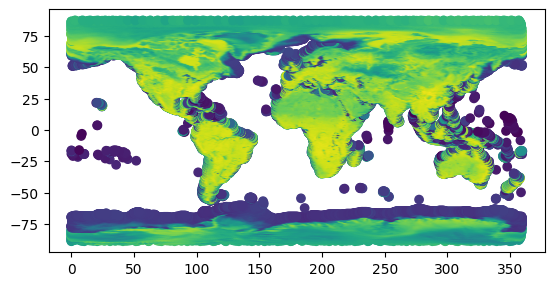

In [19]:
gdf.plot("Emis37H")

In [62]:
# Try to create a xr.DataArray from the gdf
import xarray as xr

# grid_width = 0.25
# grid_height = 0.25
# lon_min, lon_max = 0.25, 360
# lat_min, lat_max = -90, 90

# num_lon_cells = int(np.ceil((lon_max - lon_min) / grid_width))
# num_lat_cells = int(np.ceil((lat_max - lat_min) / grid_height))

# grid = xr.DataArray(np.zeros((num_lat_cells, num_lon_cells)),
#                     coords={'lat': np.linspace(lat_min, lat_max, num_lat_cells),
#                             'lon': np.linspace(lon_min, lon_max, num_lon_cells)},
#                     dims=['lat', 'lon'])

# Lets load a windsat grid instead

ds = xr.load_dataset(
    "../data/raw/daily_Windsat/RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_01.nc",
    decode_times=False,
)

lat_values = ds.latitude.values
lon_values = ds.longitude.values

grid = xr.DataArray(
    np.zeros((len(lat_values), len(lon_values))),
    coords={"lat": lat_values, "lon": lon_values},
    dims=["lat", "lon"],
)

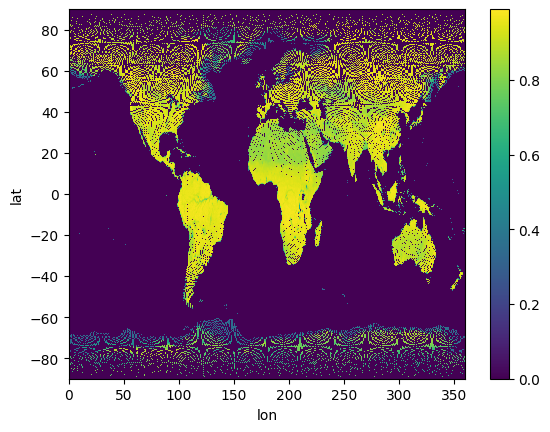

In [63]:
for index, point in gdf.iterrows():
    lon_idx = int((point.geometry.x - lon_values[0]) / (lon_values[1] - lon_values[0]))
    lat_idx = int((point.geometry.y - lat_values[0]) / (lat_values[1] - lat_values[0]))

    grid[lat_idx, lon_idx] = gdf["Emis19H"][index]

grid.plot()

In [102]:
grid.isel(lat=0, lon=0)

<xarray.DataArray ()> Size: 8B
array(0.)
Coordinates:
    lat      float32 4B -89.88
    lon      float32 4B 0.125

In [33]:
# Create a gridded version o fthe geopandas dataframe
import xarray as xr
import numpy as np

xmin, ymin, xmax, ymax = gdf.total_bounds
cell_size = 0.25
xcoords = np.arange(xmin, xmax, cell_size)
ycoords = np.arange(ymin, ymax, cell_size)

# Create the meshgrid

X, Y = np.meshgrid(xcoords, ycoords)

# Empty array:
counts = np.zeros_like(X)

In [34]:
for index, point in gdf.iterrows():
    x = point.geometry.x
    y = point.geometry.y
    # Find the indices of the grid cell where the point belongs
    i = int((x - xmin) / cell_size)
    j = int((y - ymin) / cell_size)
    # Increment the count for that grid cell
    if 0 <= i < counts.shape[1] and 0 <= j < counts.shape[0]:
        counts[j, i] = gdf["Emis19H"][index]

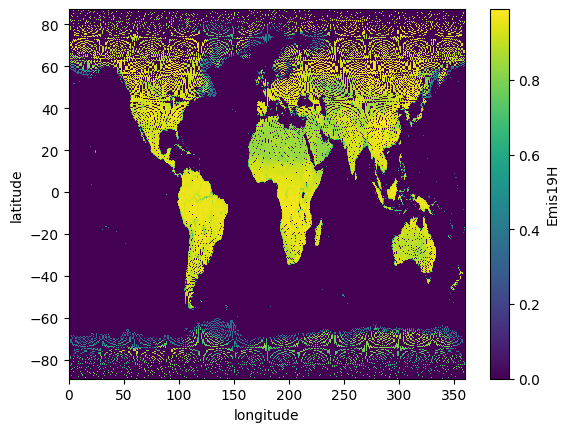

In [35]:
# Create an xarray DataArray with the counts
data_array = xr.DataArray(
    counts, coords=[ycoords, xcoords], dims=["latitude", "longitude"]
)

# Optionally, convert to dataset if needed
dataset = data_array.to_dataset(name="Emis19H")
dataset.Emis19H.plot()

In [41]:
coords = gdf.geometry

In [46]:
lat = [p.y for p in coords]
lon = [p.x for p in coords]

# Get the grid fro lat and lon
lat_grid = np.unique(lat)
lon_grid = np.unique(lon)

In [48]:
lat_grid.shape, lon_grid.shape

((694,), (163958,))

(array([ 4870.,  9839., 18836., 20685.,  9928., 24179., 21621., 23414.,
        21714.,  8872.]),
 array([  0.        ,  35.98695652,  71.97391304, 107.96086957,
        143.94782609, 179.93478261, 215.92173913, 251.90869565,
        287.89565217, 323.8826087 , 359.86956522]),
 <BarContainer object of 10 artists>)

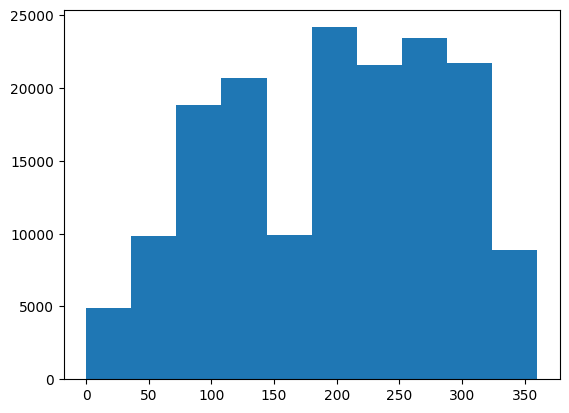

In [55]:
import matplotlib.pyplot as plt

plt.hist(lon_grid)

# Telsem2AtlasData class implementation
Let´s try to create a proper pyhton class with methods and such

In [38]:
import os
import numpy as np
import geopandas
import pandas as pd
from shapely.geometry import Point

class Telsem2AtlasData:
    def __init__(self, path:str):
        # number of lines in the atlas
        self.ndat = None
        # number of channels in the atlas
        self.nchan = 7
        # name of the atlas (including version number)
        self.path = path

        # Directory where the atlas data is stored
        self.dir = os.path.dirname(self.path)
        self.name = os.path.basename(self.path)
        
        # resolution of the atlas (equal-area)
        self.dlat = 0.25
        # number of cells per lat band
        self.ncells = None
        # the first cellnumber of lat band
        self.firstcell = None
        # limits of the spatial domain (flagged if global)
        self.lat1 = None
        self.lat2 = None
        self.lon1 = None
        self.lon2 = None
        # Emissivities
        self.emis = None  # emis(ndat,nchan)
        # Correlations
        self.correl = None  # correl(10,nchan,nchan)
        # Emissivity uncertainties (std)
        self.emis_err = None  # emis_err(ndat,nchan)
        # Surface class
        self.class1 = None
        self.class2 = None
        # cellnumber of each of the pixels in the atlas
        self.cellnum = None
        # "Correspondance" vector indicating that for the ith element, the j so that EMIS(j,...) is the emissivity of cellnumber i.
        self.correspondance = None  # correspondance(660066)
        errorstatus_fatal = -1

        # Added:
        self.coordinates = None

    def equare(self):
        """ 
        Equal area computations
        """
        dlat = self.dlat
        ncells = self.ncells
        firstcell = self.firstcell

        maxlat = int(180.0 / dlat)
        maxlon = int(360.0 / dlat)

        tocell = np.zeros((maxlon, maxlat), dtype=np.int32)

        REARTH = 6371.2
        PI = np.pi
        RCELAT = (dlat * PI) / 180.0
        TOTCEL = 0

        HEZON = REARTH * np.sin(RCELAT)
        AEZON = 2.0 * PI * REARTH * HEZON
        AECELL = (AEZON * dlat) / 360.0

        MAXLT2 = maxlat // 2
        for lat in range(1, MAXLT2 + 1):
            XLATB = (lat - 1) * dlat
            XLATE = XLATB + dlat
            RLATB = (2.0 * PI * XLATB) / 360.0
            RLATE = (2.0 * PI * XLATE) / 360.0

            HTB = REARTH * np.sin(RLATB)
            HTE = REARTH * np.sin(RLATE)
            HTZONE = HTE - HTB
            AZONE = 2.0 * PI * REARTH * HTZONE

            RCELLS = AZONE / AECELL
            ICELLR = int(RCELLS + 0.5)

            TOTCEL += 2 * ICELLR

            lat1 = lat + MAXLT2
            lat2 = MAXLT2 + 1 - lat
            ncells[lat1 - 1] = ICELLR
            ncells[lat2 - 1] = ICELLR

        numcel = 0
        for lat in range(1, maxlat + 1):
            numcls = ncells[lat - 1]
            for lon in range(1, numcls + 1):
                numcel += 1
                tocell[lon - 1, lat - 1] = numcel

        for i in range(1, maxlat + 1):
            if i == 1:
                firstcell[i - 1] = 1
            else:
                firstcell[i - 1] = firstcell[i - 2] + ncells[i - 2]


    def rttov_readmw_atlas(
        self,
        verbose=False,
        lat1=None,
        lat2=None,
        lon1=None,
        lon2=None,
    ):


        # TRANSITORY VARIABLES
        iiin = 21  # unit for input
        cellnum = 0
        ssmi = np.zeros(2 * 7, dtype=np.float64)
        lat, lon = 0.0, 0.0
        cur_class1, cur_class2 = 0, 0
        take = 0  # flag to take or not the pixel atlas for location constraints
        msg = ""

        # initialisation
        err = 0

        if self.emis is not None:
            err = errorstatus_fatal
            print("TELSEM2 atlas data structure already allocated")
            return err

        self.lat1 = -777
        self.lat2 = -777
        self.lon1 = -777
        self.lon2 = -777

        if lat1 is not None:
            self.lat1 = lat1
        if lat2 is not None:
            self.lat2 = lat2
        if lon1 is not None:
            self.lon1 = lon1 % 360.0
        if lon2 is not None:
            self.lon2 = lon2 % 360.0

        # ALLOCATION SPECIFIC TO SSMI ATLAS
        self.nchan = 7
        self.name = "ssmi_mean_emis_climato"
        self.dlat = 0.25
        self.ncells = np.zeros(int(180.0 / self.dlat), dtype=np.int32)
        self.firstcell = np.zeros(int(180.0 / self.dlat), dtype=np.int32)
        self.equare()

        # DEFINING NUMBER OF DATA
        if verbose:
            print("Reading number of data in atlas...")

        try:
            iiin_file = open(
                self.path, "r"
            )
            j = int(iiin_file.readline().strip())
            self.ndat = j
            if verbose:
                print(f"Nb data={self.ndat}")
        except IOError as e:
            print(f"Error opening the monthly input file: {e}")
            err = errorstatus_fatal
            return err

        # ALLOCATE VARIABLES
        self.emis = np.zeros((self.ndat, self.nchan), dtype=np.float64)
        self.emis_err = np.zeros((self.ndat, self.nchan), dtype=np.float64)
        self.class1 = np.zeros(self.ndat, dtype=np.int32)
        self.class2 = np.zeros(self.ndat, dtype=np.int32)
        self.cellnum = np.zeros(self.ndat, dtype=np.int32)
        self.correspondance = np.full(660066, -777, dtype=np.int32)

        ipos = 0
        for line in iiin_file:
            parts = line.strip().split()
            cellnum, ssmi_values, cur_class1, cur_class2 = (
                int(parts[0]),
                list(map(float, parts[1:15])),
                int(parts[15]),
                int(parts[16]),
            )

            take = 1
            if lat1 is not None:
                get_coordinates(cellnum, atlas, lat, lon)
                if not (lat1 <= lat <= lat2 and lon1 <= lon <= lon2):
                    take = 0

            if cur_class1 > 0 and cur_class2 > 0 and ipos < self.ndat and take == 1:
                ipos += 1
                self.emis[ipos - 1, :] = ssmi_values[:7]
                self.emis_err[ipos - 1, :] = np.sqrt(ssmi_values[7:])
                self.cellnum[ipos - 1] = cellnum
                self.class1[ipos - 1] = cur_class1
                self.class2[ipos - 1] = cur_class2
                self.correspondance[cellnum - 1] = ipos

        self.ndat = ipos
        iiin_file.close()

        # Correlation of uncertainties
        self.correl = np.zeros((10, self.nchan, self.nchan), dtype=np.float64)

        if verbose:
            print("Reading classes...")

        try:
            iiin_file = open(os.path.join(self.dir, "correlations"), "r")
            for i in range(10):
                iiin_file.readline()  # skip lines
                for j in range(7):
                    self.correl[i, j, :] = np.array(
                        list(map(float, iiin_file.readline().strip().split()))
                    )
        except IOError as e:
            print(f"Error opening the correlations input file: {e}")
            err = errorstatus_fatal
            return err
        finally:
            iiin_file.close()
        return err
    
    def get_all_coordinates(self):
        """ 
        Populate the coordinates field, giving pais of lat-lon points in a list.
        1 to 1 correspondence to self.cellnum
        """
        self.coordinates = [self.get_coordinates(c) for c in self.cellnum]
        pass

    def get_coordinates(self, cellnum: int) ->tuple[float, float]:
        """ 
        Create an equivalent geodataframe from the atlas data
        Columns: 
            Geometry (points with the lon-lat coordinates)
            7 emmisivity bands
            7 error estimation, one for each of the bands.
            2 surface classification flags for each point.
        """

        res_lat = self.dlat

        index_lat_max = int(180 / res_lat) - 1

        if cellnum >= self.firstcell[index_lat_max]:
            index_lat = index_lat_max
            lat = (index_lat - 0.5) * res_lat - 90
            index_lon = cellnum - self.firstcell[index_lat_max] + 1
            lon = (index_lon - 0.5) * (360.0 / self.ncells[index_lat])

        else:
            for i in range(1, index_lat_max + 1):
                if cellnum >= self.firstcell[i] and cellnum < self.firstcell[i + 1]:
                    index_lat = i
                    lat = (index_lat - 0.5) * res_lat - 90
                    index_lon = cellnum - self.firstcell[i] + 1
                    lon = (index_lon - 0.5) * (360.0 / self.ncells[index_lat])

        return lat, lon
    
    def to_geopandas(self) -> geopandas.GeoDataFrame:
        """ 
        Export the atlas data
        """
        if self.coordinates == None:
            print("Calculating coordinates as points")
            self.get_all_coordinates()

        lats = [c[0] for c in self.coordinates]
        lons = [(c[1] - 180) % 360 for c in self.coordinates]
        geometry = [Point(lon,lat) for lat,lon in zip(lats,lons)]

        gdf = geopandas.GeoDataFrame(geometry=geometry)

        # Create dataframes for emisivities and errors:
        emisdf = pd.DataFrame(
            self.emis,
            columns=[
                "Emis19V",
                "Emis19H",
                "Emis22V",
                "Emis37V",
                "Emis37H",
                "Emis85V",
                "Emis85H",
            ],
        )

        errdf = pd.DataFrame(
            atlas.emis_err,
            columns=[
                "VarEmis19V",
                "VarEmis19H",
                "VarEmis22V",
                "VarEmis37V",
                "VarEmis37H",
                "VarEmis85V",
                "VarEmis85H",
            ],
        )
        # surface class information
        sc1df = pd.DataFrame(atlas.class1, columns=["Surface_class1"])
        sc2df = pd.DataFrame(atlas.class2, columns=["Surface_class2"])

        return pd.concat([gdf, emisdf, errdf, sc1df, sc2df], axis=1)
    

In [39]:
atlas = Telsem2AtlasData(path =r"..\data\raw\telsem2_mw_atlas\ssmi_mean_emis_climato_01_cov_interpol_M2" )
atlas.rttov_readmw_atlas()

0

In [34]:
# Calculate all coordinates for the atlas cells
atlas.get_all_coordinates()

In [40]:
# Create a GeoDataFrame with the atlas data
gdf = atlas.to_geopandas()

Calculating coordinates as points


,geometry,Emis19V,Emis19H,Emis22V,Emis37V,Emis37H,Emis85V,Emis85H,VarEmis19V,VarEmis19H,VarEmis22V,VarEmis37V,VarEmis37H,VarEmis85V,VarEmis85H,Surface_class1,Surface_class2
0,POINT (195.429 -88.875),0.851150,0.694974,0.852954,0.860778,0.742279,0.821671,0.757044,0.013153,0.011402,0.013528,0.009487,0.014799,0.032249,0.028931,6,21
1,POINT (205.714 -88.875),0.850715,0.694205,0.852940,0.862427,0.742945,0.830328,0.764085,0.013266,0.011533,0.013675,0.009798,0.014629,0.028775,0.027550,6,21
2,POINT (216.000 -88.875),0.848923,0.688440,0.850987,0.862822,0.738313,0.845982,0.776129,0.013748,0.011874,0.014107,0.010630,0.014248,0.022000,0.024145,6,21
3,POINT (226.286 -88.875),0.848579,0.684609,0.849558,0.860756,0.732303,0.853847,0.782463,0.014283,0.012490,0.014663,0.011269,0.014213,0.017029,0.021772,6,21
4,POINT (236.571 -88.875),0.849775,0.683814,0.849110,0.857601,0.727091,0.856796,0.785715,0.014933,0.013638,0.015330,0.011832,0.014765,0.013491,0.020421,6,21


<Axes: >

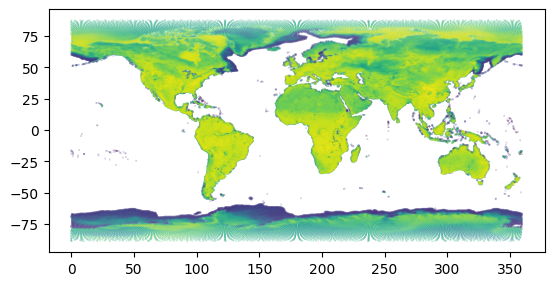

In [45]:
gdf.plot("Emis37H", s=0.01)

In [52]:
# Export it into a geojson file:
filename = os.path.join(
    r"..\data\processed\GeoTelsem",os.path.basename(atlas.path) + ".geojson"
)
print("Saving file: ",filename)
gdf.to_file(filename, driver="GeoJSON")

Saving file:  ..\data\processed\GeoTelsem\ssmi_mean_emis_climato_01_cov_interpol_M2.geojson
